In [1]:
import numpy as np
import cv2 as cv
from skimage.morphology import skeletonize
import glob
import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from PIL import Image
import imageio

In [2]:
data = pd.read_excel("data.xlsx")

In [3]:
patch_size = int(round(250*1.19))
heatmaps = list()
for a in tqdm.tqdm(glob.glob("skeletons/*.png")):
    im = cv.imread(a, cv.IMREAD_GRAYSCALE)
    heatmap = np.zeros((im.shape[0]//patch_size, im.shape[1]//patch_size))
    ark = a[10:-7]
    for x in range(0, im.shape[1], patch_size):
        if im.shape[1] - x < patch_size:
            continue
        for y in range(0, im.shape[0], patch_size):
            if im.shape[0] - y < patch_size:
                continue
            density = np.sum(im[y:y+patch_size, x:x+patch_size])
            heatmap[y//patch_size, x//patch_size] = density
    heatmaps.append((ark,heatmap))               

100%|████████████████████████████████████████████████████████████████████████████████| 346/346 [02:00<00:00,  2.87it/s]


In [4]:
years = []
for ark, heatmap in heatmaps:
    year = data[data.ark == "12148_"+ark].date.values[0]
    if year == year:
        years.append(year)
q=10
groups = np.percentile(years, range(q,101,q))
groups

array([1830. , 1840. , 1842. , 1846. , 1852. , 1862. , 1876.7, 1889. ,
       1907. , 1949. ])

In [5]:
years_heatmaps = {}
for ark, heatmap in heatmaps:
    year = data[data.ark == "12148_"+ark].date.values[0]
    
    if year != year:
        continue
        
    i = 0
    while year > groups[i]:
        i+=1
    if i == 0 or i == 9:
        continue
    if i in years_heatmaps.keys():
        years_heatmaps[i].append(heatmap)
    else:
        years_heatmaps[i] = [heatmap]

In [6]:
max_value = 0
for y in sorted(years_heatmaps.keys()):
    size = 100
    
    im = np.array(np.mean(years_heatmaps[y], axis=0))
    new_data = np.zeros(np.array(im.shape) * size)
    for j in range(im.shape[0]):
        for k in range(im.shape[1]):
            new_data[j * size: (j+1) * size, k * size: (k+1) * size] = im[j, k]
            max_value = max(max_value, im[j, k])
    years_heatmaps[y] = new_data
    #plt.imsave(f"years_density/{y}.png", new_data)

In [7]:
years_heatmaps.keys()

dict_keys([8, 1, 7, 5, 4, 3, 6, 2])

In [21]:
differences = {}
for i in range(2,len(groups)-1):
    differences[i] = years_heatmaps[i]-years_heatmaps[i-1]
    
min_value = 99999
max_value = -99999
for key, value in differences.items():
    for y in range(value.shape[0]):
        for x in range(value.shape[1]):
            max_value = max(max_value, value[y][x])
            min_value = min(min_value, value[y][x])

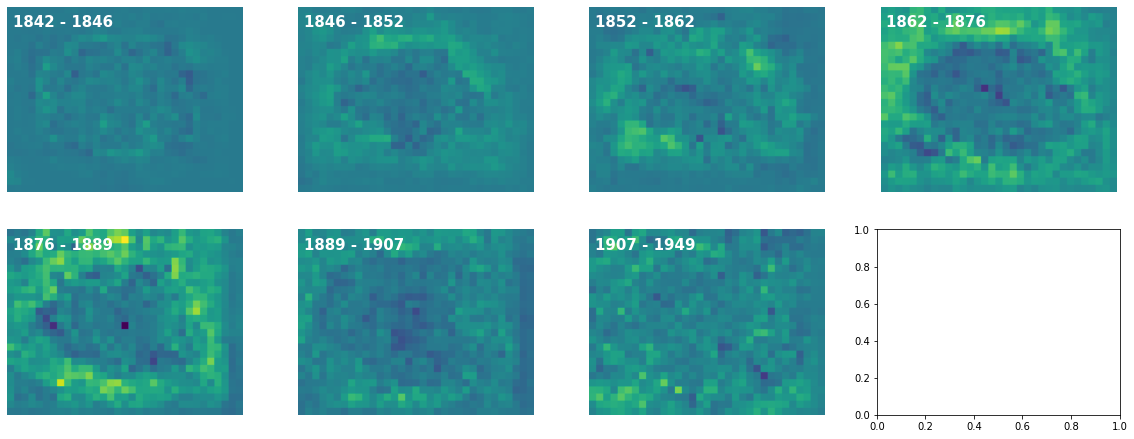

In [22]:
fig, axs = plt.subplots(2,4, figsize=(20,7.5))
for ax, y in zip(axs.flatten(), sorted(differences.keys())):
    ax.text(75,280,f"{int(groups[y])} - {int(groups[y+1])}", color="white", fontweight='heavy', fontsize=15)
    ax.axis("off")
    ax.imshow(differences[y], vmax=max_value, vmin=min_value)

In [6]:
print(len(years_heatmaps.keys()))

23


In [34]:
with imageio.get_writer('evolution.gif', mode='I') as writer:
    for filename in sorted(glob.glob("years_density/*.png")):
        image = imageio.imread(filename)
        writer.append_data(image)

In [27]:
np.max(differences[2])

309.6923076923076